# London Crime

In this notebook I will explore the past decade of all recorded crime in London, I will look for any trends in crime and vizualise the most at risk London boroughs by crime type.

The data for this exploration can be found on the opensource London Datastore: https://data.london.gov.uk/dataset/mps-monthly-crime-dahboard-data

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

## Load Data

In [3]:
df_offs = pd.read_csv('data
                      /Monthly Crime New Cats Borough Level Offs Type.csv')
df_SDs = pd.read_csv('data/Monthly Crime New Cats Borough Level SDs Type.csv')

## Initial Exploration

We have two datasets that hold information relating to all recorded offenses and sanction detections within each borough of London dating from 2012 to the present day.

Sanction detections can be defined as offenses that have been brought to justice, they are defined as 'offences that are cleared up through a formal sanction to the offender'.

Both datasets contain statistics related to various categories and sub-categories of crime.

We can begin to analyze trending rates of various crimes in each borough of London, we can also look into trends relating to the proportion of detected crimes.

In [4]:
df_offs.isna().sum().sum()
, df_SDs.isna().sum().sum()

(0, 0)

We have no null values in either dataset

In [5]:
df_offs.shape, df_SDs.shape

((1848, 131), (1848, 131))

Both datasets are of the same shape

In [6]:
df_offs.head(2)

,Borough,MajorText,MinorText,201201,201202,201203,201204,201205,201206,201207,...,202111,202112,202201,202202,202203,202204,202205,202206,202207,202208
0,Aviation Security(SO18),Miscellaneous Crimes Against Society,Absconding from Lawful Custody,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,Miscellaneous Crimes Against Society,Absconding from Lawful Custody,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_SDs.head(2)

,Borough,MajorText,MinorText,201201,201202,201203,201204,201205,201206,201207,...,202111,202112,202201,202202,202203,202204,202205,202206,202207,202208
0,Aviation Security(SO18),Miscellaneous Crimes Against Society,Absconding from Lawful Custody,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,Miscellaneous Crimes Against Society,Absconding from Lawful Custody,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Confirmation that both datasets have identical data structures

(df_SDs.columns == df_offs.columns).all() & (df_SDs.index == df_offs.index).all() 

True

I am going to start by pivoting and transposing these tables to make the data simpler to access and understand at each level (borough, crime & sub-crime). Dates will be indexed as datetime objects for time-series analysis

In [9]:
df_SDs_pivot = df_SDs.pivot_table(index=['Borough','MajorText','MinorText'])
df_offs_pivot = df_offs.pivot_table(index=['Borough','MajorText','MinorText'])

df_SDs_pivot_transpose = df_SDs_pivot.T
df_offs_pivot_transpose = df_offs_pivot.T
df_SDs_pivot_transpose.index = pd.to_datetime(df_SDs_pivot_transpose.index, format='%Y%m')#.to_period('m')
df_offs_pivot_transpose.index = pd.to_datetime(df_offs_pivot_transpose.index, format='%Y%m')#.to_period('m')

In [10]:
df_offs_pivot_transpose.head(2)

Borough      Aviation Security(SO18)                  \
MajorText  Arson and Criminal Damage                   
MinorText                      Arson Criminal Damage   
2012-01-01                         0               4   
2012-02-01                         0               6   

Borough                                                              \
MajorText                           Burglary                          
MinorText  Burglary - Business and Community Burglary - Residential   
2012-01-01                                 0                      0   
2012-02-01                                 0                      0   

Borough                                                                        \
MajorText     Drug Offences                      Historical Fraud and Forgery   
MinorText  Drug Trafficking Possession of  Drugs Historical Fraud and Forgery   
2012-01-01                0                   12                           18   
2012-02-01                1                   10                           12   

Borough                                                                       \
MajorText  Miscellaneous Crimes Against Society                                
MinorText        Absconding from Lawful Custody Aiding Suicide Bail Offences   
2012-01-01                                    0              0             0   
2012-02-01                                    0              0             0   

Borough     ... Westminster                                \
MajorText   ...       Theft                                 
MinorText   ... Other Theft Shoplifting Theft from Person   
2012-01-01  ...        1843         337               842   
2012-02-01  ...        1578         335               672   

Borough                                                                \
MajorText           Vehicle Offences                                    
MinorText  Aggravated Vehicle Taking Interfering with a Motor Vehicle   
2012-01-01                         0                                8   
2012-02-01                         0                                4   

Borough                                                                   \
MajorText                                                                  
MinorText  Theft from a Motor Vehicle Theft or Taking of a Motor Vehicle   
2012-01-01                        176                                 52   
2012-02-01                        129                                 19   

Borough                                                      \
MajorText  Violence Against the Person                        
MinorText                     Homicide Violence with Injury   
2012-01-01                           0                  271   
2012-02-01                           0                  211   

Borough                             
MajorText                           
MinorText  Violence without Injury  
2012-01-01                     271  
2012-02-01                     287  

[2 rows x 1848 columns]

Now, lets begin to look at our boroughs and the different categories of crimes recorded

In [11]:
df_offs_pivot_transpose.loc[:,'Westminster'].sum()

MajorText                             MinorText                                                        
Arson and Criminal Damage             Arson                                                                   441
                                      Criminal Damage                                                       22759
Burglary                              Burglary - Business and Community                                     20809
                                      Burglary - Residential                                                16667
Drug Offences                         Drug Trafficking                                                       2088
                                      Possession of  Drugs                                                  31241
Historical Fraud and Forgery          Historical Fraud and Forgery                                           2567
Miscellaneous Crimes Against Society  Absconding from Lawful Custody                              

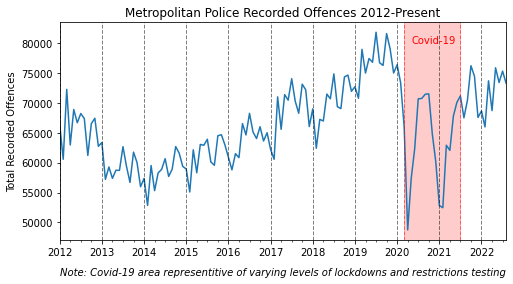

In [34]:
fig, ax = plt.subplots(figsize=(8,4))
df_offs_pivot_transpose.sum(axis=1).plot()

for xc in ax.get_xticks():
    plt.axvline(x=xc, color='black', linestyle='--', lw=1, alpha=0.5 )
    
plt.axvline(x='03-2020', color='red', linestyle='--', lw=1, alpha=0.5 )
plt.axvline(x='07-2021', color='red', linestyle='--', lw=1, alpha=0.5 )    
    
ax.axvspan('03-2020', '07-2021', color='red', alpha=0.2)

ax.set_ylabel('Total Recorded Offences')
ax.set_title('Metropolitan Police Recorded Offences 2012-Present')   
ax.text('05-2020', 80000, 'Covid-19', color='red')

#ax.text('01-2012', 40000, 'Note: Covid-19 area representitive of varying levels of lockdowns and restrictions', fontstyle='italic')
ax.set_xlabel('Note: Covid-19 area representitive of varying levels of lockdowns and restrictions testing', loc='left', labelpad=10, fontstyle='italic')
plt.show();

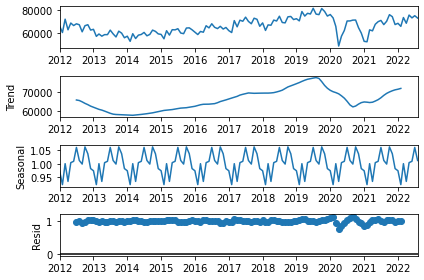

In [13]:
decompose_result = seasonal_decompose(df_offs_pivot_transpose.sum(axis=1), model='multiplicative')
decompose_result.plot();

<AxesSubplot:>

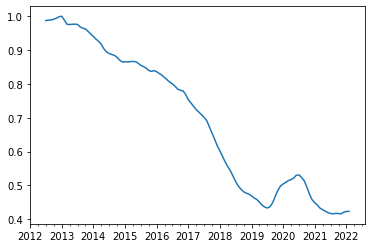

In [27]:
(decompose_result.trend / decompose_result.trend.max()).plot()

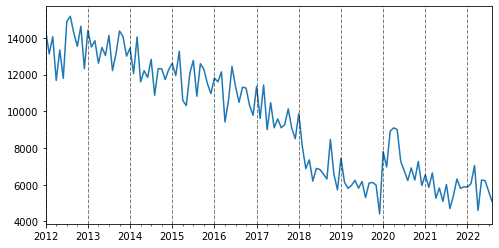

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
df_SDs_pivot_transpose.sum(axis=1).plot()

for xc in ax.get_xticks():
    plt.axvline(x=xc, color='black', linestyle='--', lw=1, alpha=0.5 )
    
plt.show();

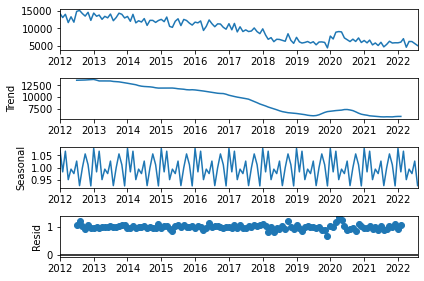

In [15]:
decompose_result = seasonal_decompose(df_SDs_pivot_transpose.sum(axis=1), model='multiplicative')
decompose_result.plot();

In [16]:
decompose_result.

SyntaxError: invalid syntax (4130574300.py, line 1)